# Get Itemid List

This script is used for collecting all itemids in the database. Itemids are ids of features.

In this task we only collect itemids from the following tables:
- inputevents
- outputevents
- chartevents
- labevents
- microbiologyevents
- prescriptions

In [1]:
from __future__ import print_function

import psycopg2
import datetime
import sys
from operator import itemgetter, attrgetter, methodcaller
import numpy as np
import itertools
import os.path
import matplotlib.pyplot as plt
import math
from multiprocessing import Pool, Process, Lock, cpu_count
from multiprocessing.sharedctypes import Value, Array
from ctypes import Structure, c_double, c_int
from tqdm import tqdm_notebook as tqdm
import sys

from utils import getConnection

%matplotlib inline

In [2]:
res_dir = '/media/data/mimic/res'

In [3]:
try:
    conn = getConnection()
    print('Connected to Postgre Database!')
except:
    print('Fail to connect!')

Connected to Postgre Database!


In [4]:
# load admission_ids
_adm = np.load(f'{res_dir}/admission_ids.npy', allow_pickle=True).tolist()
admission_ids = _adm['admission_ids']
admission_ids_txt = _adm['admission_ids_txt']

## Itemids from inputevents

Data from Carevue and Metavision is separately stored in TABLE INPUTEVENTS_CV and TABLE INPUTEVENTS_MV. Inputevents from Metavision have itemids >= 200000, and those from Carevue have itemids in [30000, 49999].

In [5]:
# itemid from inputevents
# sql = 'select distinct itemid from mimiciii.inputevents_cv where itemid >= 30000 and itemid <= 49999'
sql = '''
with inputitemids as (
        select distinct itemid from mimiciii.inputevents_mv where itemid >= 200000
        union
        select distinct itemid from mimiciii.inputevents_cv where itemid >= 30000 and itemid <= 49999
    )
select distinct itemid from inputitemids
'''
cur = conn.cursor()
cur.execute(sql)
res = cur.fetchall()
input_itemid = [r[0] for r in res]
input_itemid_txt = ','.join(map(str, input_itemid))

print("len(input_itemid) = ", len(input_itemid))

len(input_itemid) =  3216


## Itemids from outputevents

We only need to collect all distinct itemids in TABLE OUTPUTEVENTS.

In [6]:
# itemid from outputevents
# sql = 'select distinct itemid from mimiciii.outputevents where itemid >= 30000 and itemid <= 49999'
sql = 'select distinct itemid from mimiciii.outputevents'
cur = conn.cursor()
cur.execute(sql)
res = cur.fetchall()
output_itemid = [r[0] for r in res]
output_itemid_txt = ','.join(map(str, output_itemid))

print("len(output_itemid) = ", len(output_itemid))

len(output_itemid) =  1155


## Itemids from chartevents

We only need to collect all distinct itemids in TABLE CHARTEVENTS.

In [7]:
# itemid from chartevents, should collect all ids <= 49999
# sql = 'select distinct itemid from mimiciii.chartevents where itemid <= 49999'
sql = 'select distinct itemid from mimiciii.chartevents'
cur = conn.cursor()
cur.execute(sql)
res = cur.fetchall()
chart_itemid = [r[0] for r in res]
chart_itemid_txt = ','.join(map(str, chart_itemid))

print("len(chart_itemid) = ", len(chart_itemid))

len(chart_itemid) =  6463


## Itemids from labevents

We only need to collect all distinct itemids in TABLE LABEVENTS.

In [8]:
# itemid from labevenets
sql = 'select distinct itemid from mimiciii.labevents'
cur = conn.cursor()
cur.execute(sql)
res = cur.fetchall()
lab_itemid = [r[0] for r in res]
lab_itemid_txt = ','.join(map(str, lab_itemid))

print("len(lab_itemid) = ", len(lab_itemid))

len(lab_itemid) =  726


## Itemids from microbiologyevents

We need to collect 4 kinds of itemids:
- spec_itemid
- org_itemid
- ab_itemid
- tuple of all above

In [9]:
# itemid from microbiologyevents
sql = 'select distinct (spec_itemid,org_itemid,ab_itemid),spec_itemid,org_itemid,ab_itemid from mimiciii.microbiologyevents'
cur = conn.cursor()
cur.execute(sql)
res = cur.fetchall()
microbio_itemid = []
for r in res:
    ele = r[0][1:-1].split(',')
    for t in range(len(ele)):
        try:
            ele[t] = int(ele[t])
        except:
            ele[t] = None
    microbio_itemid.append(tuple(ele))

print("len(microbio_itemid) = ", len(microbio_itemid))

len(microbio_itemid) =  9154


## Itemids from prescriptions

We only need to collect all distinct itemids in TABLE PRESCRIPTIONS.

In [10]:
# itemid from prescriptions
sql = 'select distinct formulary_drug_cd from mimiciii.prescriptions'
cur = conn.cursor()
cur.execute(sql)
res = cur.fetchall()
prescript_itemid = [r[0] for r in res]

print("len(prescript_itemid) = ", len(prescript_itemid))

len(prescript_itemid) =  3268


In [11]:
database = {'input':input_itemid,
            'output':output_itemid,
            'chart':chart_itemid,
            'lab':lab_itemid,
            'microbio':microbio_itemid,
            'prescript':prescript_itemid}
np.save(f'{res_dir}/itemids.npy',database);
print('saved!')

saved!


## Histograms of itemids

For each table we draw the histogram showing the number of admissions which have any record of each itemid.

In [21]:
def getConnect():
    return getConnection()


# function to execute a sql and store result to specific location of an array, used for parallel query

def queryAndStoreSql(sqls_itemids):
    tconn = getConnect()
    subresults = []
    for sql, itemid in tqdm(sqls_itemids):
        tcur = tconn.cursor()
        tcur.execute(sql)
        r2 = tcur.fetchall()
        subresults.append((itemid, int(r2[0][0])))
    tconn.close()
    return subresults

def getNumberOfAdmissionThatUseStatId(sql, itemids, admission_ids_txt, savefile, numworkers=cpu_count() // 2):
    starttime = datetime.datetime.now()
    p = Pool(numworkers)
#     numberOfAdmissionThatUseItemid = [(0, 0) for t in range(len(itemids))]
    numberOfAdmissionThatUseItemid = []
    sqls_itemids = []
    for t, itemid in enumerate(itemids):
        itemidstr = '= {0}'.format(itemid)
        if itemid is None:
            itemidstr = 'is null'
        sqls_itemids.append((sql.format(itemidstr), itemid))
    sqls_itemids_units = np.array_split(sqls_itemids, numworkers)
    for sqls_itemids_unit in sqls_itemids_units:
        numberOfAdmissionThatUseItemid.append(p.apply_async(queryAndStoreSql,
                                                          args=(sqls_itemids_unit,)))
    p.close()
    p.join()

    numberOfAdmissionThatUseItemid = [t.get() for t in numberOfAdmissionThatUseItemid]
    numberOfAdmissionThatUseItemid = list(itertools.chain.from_iterable(numberOfAdmissionThatUseItemid))
    numberOfAdmissionThatUseItemid = sorted(numberOfAdmissionThatUseItemid, key=lambda tup: tup[1])
    numberOfAdmissionThatUseItemid.reverse()
    print(len(numberOfAdmissionThatUseItemid))
    sys.stdout.flush()
    np.save(savefile, numberOfAdmissionThatUseItemid)

def getNumberOfAdmissionThatUseStatIdBio(itemids, admission_ids_txt, savefile, numworkers=cpu_count() // 2):
    starttime = datetime.datetime.now()
    p = Pool(numworkers)
    numberOfAdmissionThatUseItemid = []
    sqls_itemids = []
    for t, itemid in enumerate(itemids):
        sql = 'select count(distinct hadm_id) from mimiciii.microbiologyevents where hadm_id in (select * from admission_ids)'
        if (itemid[0] != None):
            sql += ' and spec_itemid=' + str(itemid[0])
        else:
            sql += ' and spec_itemid is null'
        if (itemid[1] != None):
            sql += ' and org_itemid=' + str(itemid[1])
        else:
            sql += ' and org_itemid is null'
        if (itemid[2] != None):
            sql += ' and ab_itemid=' + str(itemid[2])
        else:
            sql += ' and ab_itemid is null'
        sqls_itemids.append((sql, itemid))
    sqls_itemids_units = np.array_split(sqls_itemids, numworkers)
    for sqls_itemids_unit in sqls_itemids_units:
        numberOfAdmissionThatUseItemid.append(p.apply_async(queryAndStoreSql,
                                                          args=(sqls_itemids_unit,)))
    p.close()
    p.join()

    numberOfAdmissionThatUseItemid = [t.get() for t in numberOfAdmissionThatUseItemid]
    numberOfAdmissionThatUseItemid = list(itertools.chain.from_iterable(numberOfAdmissionThatUseItemid))
    numberOfAdmissionThatUseItemid = sorted(numberOfAdmissionThatUseItemid, key=lambda tup: tup[1])
    numberOfAdmissionThatUseItemid.reverse()
    print(len(numberOfAdmissionThatUseItemid))
    np.save(savefile, numberOfAdmissionThatUseItemid)

def getNumberOfAdmissionThatUseStatIdPrescript(sql, itemids, admission_ids_txt, savefile, numworkers=cpu_count() // 2):
    starttime = datetime.datetime.now()
    p = Pool(numworkers)
    numberOfAdmissionThatUseItemid = []
    sqls_itemids = []
    for t, itemid in enumerate(itemids):
        itemidstr = '= \'{0}\''.format(itemid)
        if itemid is None:
            itemidstr = 'is null'
        sqls_itemids.append((sql.format(itemidstr), itemid))
    sqls_itemids_units = np.array_split(sqls_itemids, numworkers)
    for sqls_itemids_unit in sqls_itemids_units:
        numberOfAdmissionThatUseItemid.append(p.apply_async(queryAndStoreSql,
                                                          args=(sqls_itemids_unit,)))
    p.close()
    p.join()

    numberOfAdmissionThatUseItemid = [t.get() for t in numberOfAdmissionThatUseItemid]
    numberOfAdmissionThatUseItemid = list(itertools.chain.from_iterable(numberOfAdmissionThatUseItemid))
    numberOfAdmissionThatUseItemid = sorted(numberOfAdmissionThatUseItemid, key=lambda tup: tup[1])
    numberOfAdmissionThatUseItemid.reverse()
    print(numberOfAdmissionThatUseItemid)
    sys.stdout.flush()
    np.save(savefile, numberOfAdmissionThatUseItemid)
    
# load itemids
itemids = np.load(f'{res_dir}/itemids.npy', allow_pickle=True).tolist()




In [24]:
print(sys.stdout)

In [15]:
# labevent histogram
# print(itemids['lab'])
sql = 'select count(distinct hadm_id) from mimiciii.labevents where itemid {0} AND hadm_id in (select * from admission_ids)'
getNumberOfAdmissionThatUseStatId(sql, itemids['lab'], admission_ids_txt,
                                  f'{res_dir}/labevent_numberOfAdmissionThatUseItemid.npy')

<ipython-input-14-52f1a67f9f28>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sql, itemid in tqdm(sqls_itemids):
<ipython-input-14-52f1a67f9f28>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sql, itemid in tqdm(sqls_itemids):
<ipython-input-14-52f1a67f9f28>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sql, itemid in tqdm(sqls_itemids):
<ipython-input-14-52f1a67f9f28>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sql, itemid in tqdm(sqls_itemids):
<ipython-input-14-52f1a67f9f28>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_n

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

<ipython-input-14-52f1a67f9f28>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sql, itemid in tqdm(sqls_itemids):
<ipython-input-14-52f1a67f9f28>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sql, itemid in tqdm(sqls_itemids):
<ipython-input-14-52f1a67f9f28>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sql, itemid in tqdm(sqls_itemids):


  0%|          | 0/17 [00:00<?, ?it/s]

<ipython-input-14-52f1a67f9f28>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sql, itemid in tqdm(sqls_itemids):


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

<ipython-input-14-52f1a67f9f28>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sql, itemid in tqdm(sqls_itemids):


  0%|          | 0/17 [00:00<?, ?it/s]

<ipython-input-14-52f1a67f9f28>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sql, itemid in tqdm(sqls_itemids):


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

<ipython-input-14-52f1a67f9f28>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sql, itemid in tqdm(sqls_itemids):


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

726


In [22]:
# microbio histogram
# print(itemids['microbio'])
getNumberOfAdmissionThatUseStatIdBio(itemids['microbio'], admission_ids_txt,
                                  f'{res_dir}/microbio_numberOfAdmissionThatUseItemid.npy')



In [18]:
# prescript histogram
# print(itemids['prescript'])
sql = 'select count(distinct hadm_id) from mimiciii.prescriptions where formulary_drug_cd {0} and hadm_id in (select * from admission_ids)'
getNumberOfAdmissionThatUseStatIdPrescript(sql, itemids['prescript'], admission_ids_txt,
                                  f'{res_dir}/prescript_numberOfAdmissionThatUseItemid.npy')

726


Text(0, 0.5, 'number of admissions using this feature')

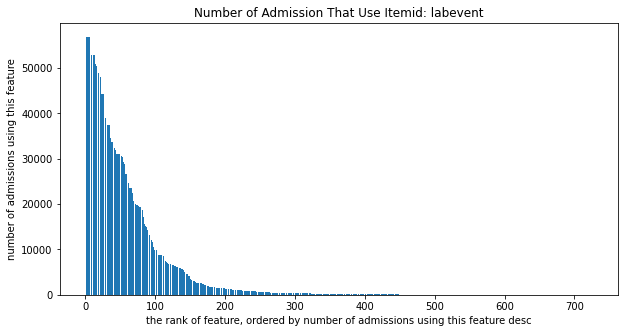

In [3]:
# finish stats in seperate py file for the convenience of multi-processing
labevent_histo = np.load(f'{res_dir}/labevent_numberOfAdmissionThatUseItemid.npy', allow_pickle=True).tolist()
print(len(labevent_histo))
plt.figure(figsize=(10,5))
plt.bar([i for i in range(len(labevent_histo))],[int(r[1]) for r in labevent_histo])
plt.title('Number of Admission That Use Itemid: labevent')
plt.xlabel('the rank of feature, ordered by number of admissions using this feature desc')
plt.ylabel('number of admissions using this feature')

In [20]:
print(len(labevent_histo))

9154


Text(0, 0.5, 'number of admissions using this feature')

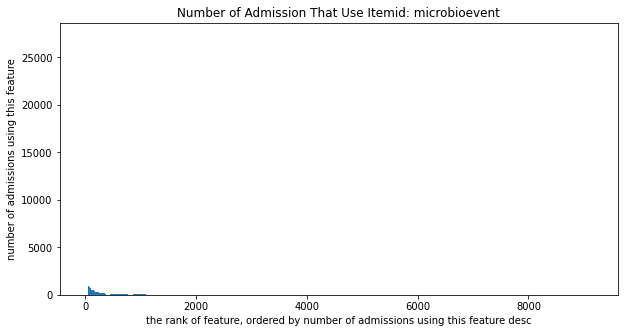

In [4]:
microbio_histo = np.load(f'{res_dir}/microbio_numberOfAdmissionThatUseItemid.npy', allow_pickle=True).tolist()
print(len(microbio_histo))
plt.figure(figsize=(10,5))
plt.bar([i for i in range(len(microbio_histo))],[int(r[1]) for r in microbio_histo])
plt.title('Number of Admission That Use Itemid: microbioevent')
plt.xlabel('the rank of feature, ordered by number of admissions using this feature desc')
plt.ylabel('number of admissions using this feature')

Text(0, 0.5, 'number of admissions using this feature')

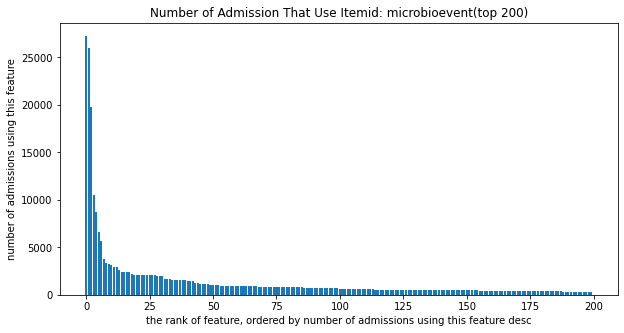

In [5]:
microbio_histo[:200]
plt.figure(figsize=(10,5))
plt.bar([i for i in range(len(microbio_histo[:200]))],[int(r[1]) for r in microbio_histo[:200]])
plt.title('Number of Admission That Use Itemid: microbioevent(top 200)')
plt.xlabel('the rank of feature, ordered by number of admissions using this feature desc')
plt.ylabel('number of admissions using this feature')

3268


Text(0, 0.5, 'number of admissions using this feature')

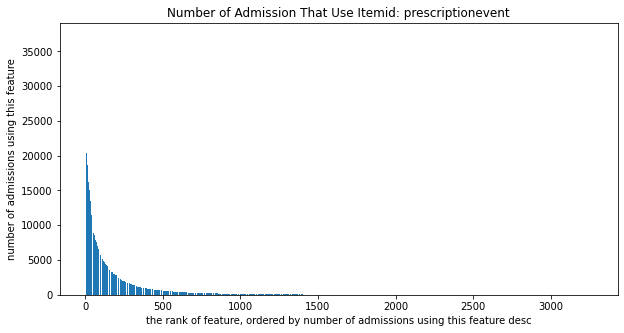

In [7]:
prescript_histo = np.load(f'{res_dir}/prescript_numberOfAdmissionThatUseItemid.npy', allow_pickle=True).tolist()
print(len(prescript_histo))
plt.figure(figsize=(10,5))
plt.bar([i for i in range(len(prescript_histo))],[int(r[1]) for r in prescript_histo])
plt.title('Number of Admission That Use Itemid: prescriptionevent')
plt.xlabel('the rank of feature, ordered by number of admissions using this feature desc')
plt.ylabel('number of admissions using this feature')

In [16]:
print(itemids['input'])

[225936, 30044, 46770, 42596, 44526, 43038, 40327, 225883, 43829, 43750, 225931, 43007, 40743, 30001, 43744, 41390, 30138, 45865, 46057, 44064, 46387, 222051, 45915, 44407, 43081, 45333, 42576, 46583, 45929, 46630, 45640, 42456, 44539, 45090, 43764, 46496, 46362, 45741, 44673, 45803, 46564, 45505, 225991, 42344, 30320, 41358, 45166, 41776, 45270, 43023, 44605, 41357, 30332, 44061, 43474, 40645, 44690, 30119, 44945, 42575, 46101, 41712, 45771, 221456, 46002, 225876, 44505, 46264, 30166, 42999, 45073, 45787, 46026, 44610, 45838, 45125, 44292, 42083, 225860, 46218, 42554, 227535, 41194, 43087, 46040, 45802, 30148, 42438, 42629, 44112, 45214, 40880, 45683, 44054, 44527, 45688, 44818, 45912, 45675, 45182, 45863, 45114, 45458, 42429, 30375, 46330, 41216, 45588, 45871, 30399, 45275, 41356, 41913, 45230, 44144, 45587, 46093, 46419, 225973, 40030, 42674, 45956, 221319, 44795, 43845, 45317, 44182, 41449, 42065, 43835, 45627, 43957, 42230, 45187, 46643, 44696, 46610, 42208, 45765, 41094, 40850, 4

In [17]:
# inputevent histogram
sql = 'select sum(count) from (\
select count(distinct hadm_id) as count from mimiciii.inputevents_mv where itemid {0} and hadm_id in (select * from admission_ids) \
union all select count(distinct hadm_id) as count from mimiciii.inputevents_cv where itemid {0} and hadm_id in (select * from admission_ids) \
) t'
getNumberOfAdmissionThatUseStatId(sql, itemids['input'], admission_ids_txt,
                                  f'{res_dir}/inputevent_numberOfAdmissionThatUseItemid.npy')

print('input finished')

# outputevent histogram
sql = 'select count(distinct hadm_id) from mimiciii.outputevents where itemid {0} AND hadm_id in (select * from admission_ids)'
getNumberOfAdmissionThatUseStatId(sql, itemids['output'], admission_ids_txt,
                                  f'{res_dir}/outputevent_numberOfAdmissionThatUseItemid.npy')

print('output finished')

# chartevent
sql = 'select count(distinct hadm_id) from mimiciii.chartevents where itemid {0} AND hadm_id in (select * from admission_ids)'
getNumberOfAdmissionThatUseStatId(sql, itemids['chart'], admission_ids_txt,
                                  f'{res_dir}/chartevent_numberOfAdmissionThatUseItemid.npy')

print('chart finished')

/home/mengcz/.pyenv/versions/anaconda3-5.1.0/envs/Benchmarking_DL_MIMICIII/lib/python3.6/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.
/home/mengcz/.pyenv/versions/anaconda3-5.1.0/envs/Benchmarking_DL_MIMICIII/lib/python3.6/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.
/home/mengcz/.pyenv/versions/anaconda3-5.1.0/envs/Benchmarking_DL_MIMICIII/lib/python3.6/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.
/home/mengcz/.pyenv/versions/anaconda3-5.1.0/envs/Be





[('30013', 25450), ('30018', 21769), ('30056', 20441), ('225158', 19301), ('220949', 16616), ('226452', 16252), ('225943', 12413), ('30026', 11958), ('30131', 11119), ('30140', 10644), ('222011', 10552), ('225975', 10290), ('225166', 10170), ('30001', 10085), ('30021', 9398), ('223258', 8703), ('225798', 8512), ('30144', 8133), ('227523', 8069), ('222168', 7675), ('30101', 7574), ('226089', 7244), ('225828', 7235), ('221794', 7135), ('225154', 6896), ('221456', 6789), ('30045', 6782), ('30128', 6713), ('30015', 6614), ('225910', 6172), ('225799', 6123), ('227522', 5998), ('225168', 5990), ('30054', 5956), ('221744', 5833), ('226361', 5736), ('226364', 5590), ('30025', 5556), ('30095', 5066), ('30121', 4940), ('225974', 4834), ('225907', 4795), ('221749', 4785), ('221668', 4515), ('226453', 4501), ('223262', 4408), ('30120', 4075), ('30005', 3777), ('221833', 3692), ('225823', 3454), ('30187', 3416), ('30118', 3377), ('221385', 3358), ('223260', 3335), ('225850', 3301), ('225152', 3

/home/mengcz/.pyenv/versions/anaconda3-5.1.0/envs/Benchmarking_DL_MIMICIII/lib/python3.6/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.
/home/mengcz/.pyenv/versions/anaconda3-5.1.0/envs/Benchmarking_DL_MIMICIII/lib/python3.6/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.
/home/mengcz/.pyenv/versions/anaconda3-5.1.0/envs/Benchmarking_DL_MIMICIII/lib/python3.6/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/home/mengcz/.pyenv/versions/anaconda3-5.1.0/envs/Benchmarking_DL_MIMICIII/lib/python3.6/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.






[('40055', 22818), ('226559', 18632), ('40054', 10499), ('226560', 7817), ('40069', 7374), ('40059', 5250), ('226627', 5011), ('40076', 4633), ('40060', 4471), ('226633', 4303), ('40065', 4022), ('43175', 3589), ('226588', 3373), ('40052', 3365), ('40064', 3213), ('40061', 3202), ('226576', 2937), ('226626', 2920), ('227510', 2624), ('40067', 2185), ('226579', 2112), ('226575', 1974), ('40071', 1853), ('226571', 1626), ('226599', 1466), ('40286', 1118), ('226580', 997), ('40049', 983), ('40048', 958), ('227511', 954), ('40094', 899), ('226573', 687), ('40053', 671), ('40051', 647), ('226561', 610), ('40367', 599), ('226583', 593), ('40288', 586), ('40072', 566), ('43176', 561), ('40085', 560), ('226589', 549), ('226582', 515), ('227701', 479), ('40294', 467), ('226631', 466), ('226632', 411), ('226600', 405), ('43174', 381), ('40070', 370), ('226625', 339), ('226604', 319), ('226597', 307), ('40087', 297), ('40058', 284), ('226593', 282), ('41707', 277), ('226590', 276), ('227488',

/home/mengcz/.pyenv/versions/anaconda3-5.1.0/envs/Benchmarking_DL_MIMICIII/lib/python3.6/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.
/home/mengcz/.pyenv/versions/anaconda3-5.1.0/envs/Benchmarking_DL_MIMICIII/lib/python3.6/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.
/home/mengcz/.pyenv/versions/anaconda3-5.1.0/envs/Benchmarking_DL_MIMICIII/lib/python3.6/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.
/home/mengcz/.pyenv/versions/anaconda3-5.1.0/envs/Be





[('926', 35069), ('211', 34902), ('31', 33892), ('80', 31087), ('467', 28090), ('829', 27448), ('813', 27410), ('811', 27402), ('791', 27361), ('837', 27357), ('781', 27354), ('828', 27241), ('618', 27231), ('742', 27228), ('788', 27225), ('212', 27224), ('787', 27218), ('646', 27216), ('161', 27210), ('930', 27205), ('916', 27205), ('925', 27205), ('920', 27205), ('69', 27205), ('919', 27205), ('927', 27205), ('924', 27205), ('762', 27205), ('935', 27205), ('917', 27204), ('432', 27196), ('184', 27188), ('723', 27186), ('454', 27182), ('198', 27178), ('674', 27177), ('617', 27175), ('479', 27165), ('861', 27164), ('478', 27155), ('428', 27151), ('425', 27151), ('599', 27150), ('593', 27149), ('814', 27142), ('27', 27117), ('707', 27114), ('833', 27112), ('644', 27096), ('210', 27083), ('704', 27068), ('159', 26925), ('84', 26919), ('82', 26918), ('86', 26917), ('85', 26917), ('88', 26915), ('83', 26915), ('87', 26908), ('54', 26890), ('32', 26838), ('678', 26665), ('677', 26659), 

3216


Text(0, 0.5, 'number of admissions using this feature')

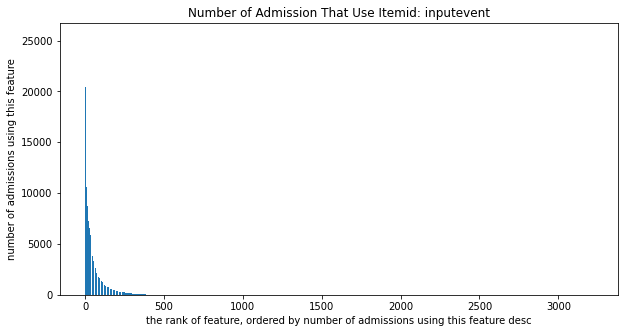

In [8]:
histo = np.load(f'{res_dir}/inputevent_numberOfAdmissionThatUseItemid.npy', allow_pickle=True).tolist()
print(len(histo))
plt.figure(figsize=(10,5))
plt.bar([i for i in range(len(histo))],[int(r[1]) for r in histo])
plt.title('Number of Admission That Use Itemid: inputevent')
plt.xlabel('the rank of feature, ordered by number of admissions using this feature desc')
plt.ylabel('number of admissions using this feature')

1155


Text(0, 0.5, 'number of admissions using this feature')

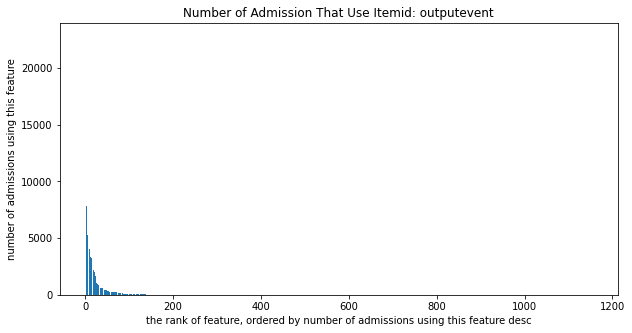

In [9]:
histo = np.load(f'{res_dir}/outputevent_numberOfAdmissionThatUseItemid.npy', allow_pickle=True).tolist()
print(len(histo))
plt.figure(figsize=(10,5))
plt.bar([i for i in range(len(histo))],[int(r[1]) for r in histo])
plt.title('Number of Admission That Use Itemid: outputevent')
plt.xlabel('the rank of feature, ordered by number of admissions using this feature desc')
plt.ylabel('number of admissions using this feature')

6463


Text(0, 0.5, 'number of admissions using this feature')

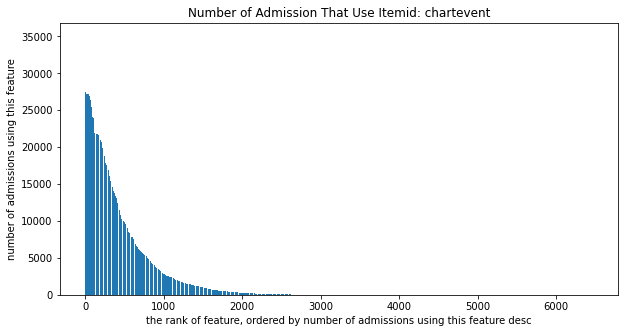

In [10]:
histo = np.load(f'{res_dir}/chartevent_numberOfAdmissionThatUseItemid.npy', allow_pickle=True).tolist()
print(len(histo))
plt.figure(figsize=(10,5))
plt.bar([i for i in range(len(histo))],[int(r[1]) for r in histo])
plt.title('Number of Admission That Use Itemid: chartevent')
plt.xlabel('the rank of feature, ordered by number of admissions using this feature desc')
plt.ylabel('number of admissions using this feature')